In [ ]:
# Cell 1: install required packages (run once)
!pip install biopython matplotlib



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.2 MB/s eta 0:00:00


In [ ]:
# Cell 2: imports and configuration
from Bio import Entrez, SeqIO
from Bio.SeqUtils import gc_fraction, molecular_weight
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Blast import NCBIWWW, NCBIXML
import matplotlib.pyplot as plt
import csv, os, zipfile
from io import StringIO

# Set your email for NCBI Entrez (required)
Entrez.email = "mathurhimika3012@gmail.com"

# Output directory
OUTDIR = "/content/annotation_output"
os.makedirs(OUTDIR, exist_ok=True)
print("Working directory:", OUTDIR)


Working directory: /content/annotation_output


In [ ]:
# Cell 3: fetch GenBank record (includes annotations) and FASTA
accession = "NM_001369735"

print("Fetching GenBank record for", accession)
handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gbwithparts", retmode="text")
record = SeqIO.read(handle, "genbank")

# Save files
gb_path = os.path.join(OUTDIR, f"{accession}.gb")
fasta_path = os.path.join(OUTDIR, f"{accession}.fasta")
SeqIO.write(record, gb_path, "genbank")
SeqIO.write(record, fasta_path, "fasta")

print("Saved:", gb_path, fasta_path)
print("Sequence length:", len(record.seq))
print("Record description:", record.description)


Fetching GenBank record for NM_001369735
Saved: /content/annotation_output/NM_001369735.gb /content/annotation_output/NM_001369735.fasta
Sequence length: 8277
Record description: Homo sapiens paternally expressed 3 (PEG3), transcript variant 24, mRNA


In [ ]:
# Cell 4: basic analysis: base counts, GC
dna_seq = record.seq
base_counts = {b: dna_seq.count(b) for b in "ATGC"}
gc_percent = round(gc_fraction(dna_seq) * 100, 2)

print("Base counts:", base_counts)
print("GC%:", gc_percent)
# save a small stats file
with open(os.path.join(OUTDIR, "sequence_stats.txt"), "w") as fh:
    fh.write(f"accession: {accession}\nlength: {len(dna_seq)}\nGC%: {gc_percent}\nbase_counts: {base_counts}\n")


Base counts: {'A': 2502, 'T': 2204, 'G': 1952, 'C': 1619}
GC%: 43.14


In [ ]:
# Cell 5: CDS-aware translation. If GenBank has CDS features, use them.
cds_proteins = []  # list of tuples (label, Seq string)
for i, feat in enumerate(record.features):
    if feat.type == "CDS":
        qualifiers = feat.qualifiers
        label = qualifiers.get("gene", [f"CDS_{i}"])[0]
        # if translation provided in GenBank, use it
        if "translation" in qualifiers:
            prot = qualifiers["translation"][0]
        else:
            # extract CDS nucleotides and translate using transl_table if present
            transl_table = int(qualifiers.get("transl_table", ['1'])[0])
            cds_seq = feat.extract(record.seq)
            prot = str(cds_seq.translate(table=transl_table, to_stop=True))
        cds_proteins.append((label, prot))

# If no CDS in record, do naive translation of whole sequence up to first stop
if not cds_proteins:
    print("[*] No CDS features found in GenBank record; performing naive translation")
    prot = str(dna_seq.translate(to_stop=True))
    cds_proteins.append(("naive_translation", prot))

# Save CDS proteins FASTA
cds_fasta_path = os.path.join(OUTDIR, "cds_proteins.fasta")
with open(cds_fasta_path, "w") as fh:
    for lbl, seq in cds_proteins:
        fh.write(f">{lbl}\n{seq}\n")

print("Saved CDS proteins to:", cds_fasta_path)
print("Number of protein sequences obtained:", len(cds_proteins))


Saved CDS proteins to: /content/annotation_output/cds_proteins.fasta
Number of protein sequences obtained: 1


In [ ]:
# Cell 6: compute properties for the principal protein (first in list)
query_label, query_prot = cds_proteins[0]
pa = ProteinAnalysis(query_prot)
prot_props = {
    "label": query_label,
    "length": len(query_prot),
    "molecular_weight": round(molecular_weight(query_prot, seq_type='protein'), 2),
    "pI": round(pa.isoelectric_point(), 2),
    "aromaticity": round(pa.aromaticity(), 4),
    "instability_index": round(pa.instability_index(), 2)
}
print("Protein properties:", prot_props)
# Save to file
with open(os.path.join(OUTDIR, "protein_properties.txt"), "w") as fh:
    for k,v in prot_props.items():
        fh.write(f"{k}: {v}\n")


Protein properties: {'label': 'PEG3', 'length': 1433, 'molecular_weight': 162716.71, 'pI': 5.22, 'aromaticity': 0.074, 'instability_index': 53.21}


In [ ]:
# Cell 7: create annotation table (CSV) with sample fields
ann_path = os.path.join(OUTDIR, "annotations.csv")
with open(ann_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Type","Start","End","Strand","Gene","Product","Protein_ID","Translation_snippet"])
    for feat in record.features:
        if feat.type in ("gene","CDS","exon"):
            start = int(feat.location.start)
            end = int(feat.location.end)
            strand = feat.location.strand
            gene = feat.qualifiers.get("gene", ["-"])[0]
            product = feat.qualifiers.get("product", ["-"])[0] if "product" in feat.qualifiers else "-"
            protein_id = feat.qualifiers.get("protein_id", ["-"])[0] if "protein_id" in feat.qualifiers else "-"
            translation = feat.qualifiers.get("translation", ["-"])[0] if "translation" in feat.qualifiers else "-"
            writer.writerow([feat.type, start, end, strand, gene, product, protein_id, (translation[:40] + "..." if translation != "-" else "-")])

print("Annotations saved to:", ann_path)


Annotations saved to: /content/annotation_output/annotations.csv


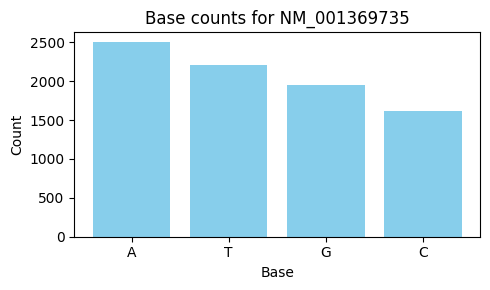

Saved: /content/annotation_output/bar_base_counts.png


In [ ]:
# Cell 8: bar chart for base counts
plt.figure(figsize=(5,3))
plt.bar(list(base_counts.keys()), list(base_counts.values()), color="skyblue")
plt.title(f"Base counts for {accession}")
plt.xlabel("Base")
plt.ylabel("Count")
bar_path = os.path.join(OUTDIR, "bar_base_counts.png")
plt.tight_layout()
plt.savefig(bar_path, dpi=150)
plt.show()
print("Saved:", bar_path)


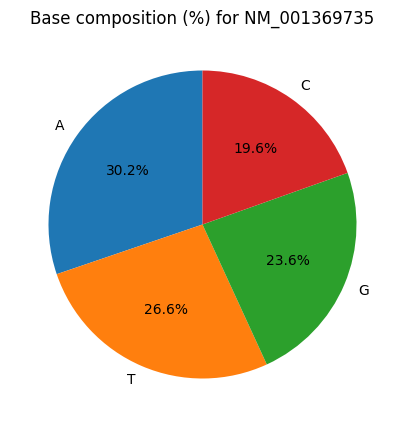

Saved: /content/annotation_output/pie_base_percent.png


In [ ]:
# Cell 9: pie chart for base percentage
plt.figure(figsize=(5,5))
labels = list(base_counts.keys())
sizes = [base_counts[b] for b in labels]
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title(f"Base composition (%) for {accession}")
pie_path = os.path.join(OUTDIR, "pie_base_percent.png")
plt.savefig(pie_path, dpi=150)
plt.show()
print("Saved:", pie_path)


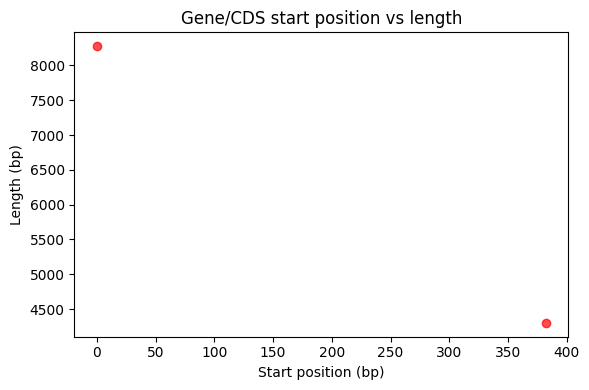

Saved: /content/annotation_output/scatter_gene_start_length.png


In [ ]:
# Cell 10: scatter plot gene start vs length (from annotation)
starts = []
lengths = []
for feat in record.features:
    if feat.type in ("gene","CDS"):
        s = int(feat.location.start)
        e = int(feat.location.end)
        starts.append(s)
        lengths.append(e-s)
plt.figure(figsize=(6,4))
plt.scatter(starts, lengths, c="red", alpha=0.7)
plt.title("Gene/CDS start position vs length")
plt.xlabel("Start position (bp)")
plt.ylabel("Length (bp)")
scatter_path = os.path.join(OUTDIR, "scatter_gene_start_length.png")
plt.tight_layout()
plt.savefig(scatter_path, dpi=150)
plt.show()
print("Saved:", scatter_path)


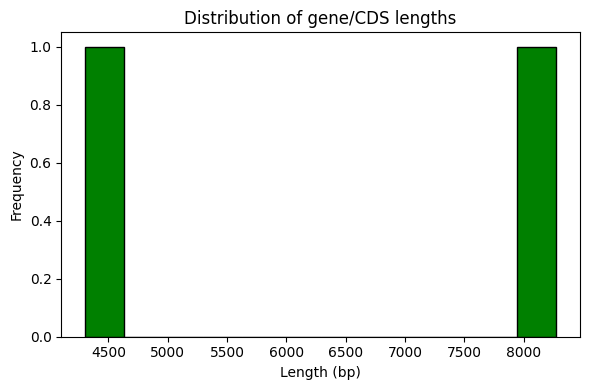

Saved: /content/annotation_output/hist_gene_lengths.png


In [ ]:
# Cell 11: histogram of gene lengths
if lengths:
    plt.figure(figsize=(6,4))
    plt.hist(lengths, bins=12, color="green", edgecolor="black")
    plt.title("Distribution of gene/CDS lengths")
    plt.xlabel("Length (bp)")
    plt.ylabel("Frequency")
    hist_path = os.path.join(OUTDIR, "hist_gene_lengths.png")
    plt.tight_layout()
    plt.savefig(hist_path, dpi=150)
    plt.show()
    print("Saved:", hist_path)
else:
    print("No gene/CDS lengths found to plot.")


In [ ]:
# Cell 12: BLASTp the principal translated protein (query_prot)
query_label, query_prot = cds_proteins[0]
print("Using protein:", query_label, "length:", len(query_prot))
print("Submitting BLASTp to NCBI (this may take 30s-2min depending on queue)...")

# Submit BLAST (nr). Be polite — don't run many times.
blast_handle = NCBIWWW.qblast("blastp", "nr", query_prot)

# Read and save XML
blast_xml = blast_handle.read()
blast_xml_path = os.path.join(OUTDIR, "blastp_result.xml")
with open(blast_xml_path, "w") as fh:
    fh.write(blast_xml)
print("Saved BLAST XML to:", blast_xml_path)


Using protein: PEG3 length: 1433
Submitting BLASTp to NCBI (this may take 30s-2min depending on queue)...
Saved BLAST XML to: /content/annotation_output/blastp_result.xml


**Note:** It appears the kernel might have restarted. Please ensure you run the installation cell (Cell 1) to install the necessary packages like `biopython` before running this cell.

In [ ]:
# Cell 13: parse BLAST XML and show top 5 hits
blast_xml_path = os.path.join(OUTDIR, "blastp_result.xml")
with open(blast_xml_path) as fh:
    blast_record = NCBIXML.read(fh)

print("=== Top BLAST hits (up to 5) ===")
top_hits = []
for alignment in blast_record.alignments[:5]:
    hsp = alignment.hsps[0]
    hit = {
        "hit_def": alignment.hit_def,
        "accession": alignment.accession,
        "length": alignment.length,
        "identities": hsp.identities,
        "align_len": hsp.align_length,
        "identity_perc": round(hsp.identities / hsp.align_length * 100, 2),
        "evalue": hsp.expect
    }
    top_hits.append(hit)
    print(f"Hit: {hit['hit_def']}\nAcc: {hit['accession']}\nLength: {hit['length']}\nIdentity: {hit['identities']}/{hit['align_len']} ({hit['identity_perc']}%)\nE-value: {hit['evalue']}\n")

# Save a small CSV of top hits
hits_csv = os.path.join(OUTDIR, "blast_top_hits.csv")
with open(hits_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["hit_def","accession","length","identities","align_len","identity_perc","evalue"])
    for h in top_hits:
        writer.writerow([h[k] for k in ("hit_def","accession","length","identities","align_len","identity_perc","evalue")])
print("Saved top hits CSV:", hits_csv)


=== Top BLAST hits (up to 5) ===
Hit: paternally-expressed gene 3 protein isoform 6 [Homo sapiens] >ref|NP_001356664.1| paternally-expressed gene 3 protein isoform 6 [Homo sapiens] >ref|NP_001356665.1| paternally-expressed gene 3 protein isoform 6 [Homo sapiens] >ref|NP_001356666.1| paternally-expressed gene 3 protein isoform 6 [Homo sapiens] >ref|NP_001356667.1| paternally-expressed gene 3 protein isoform 6 [Homo sapiens] >gb|KAI2593418.1| paternally expressed 3 [Homo sapiens] >gb|KAI4045091.1| paternally expressed 3 [Homo sapiens]
Acc: NP_001356663
Length: 1433
Identity: 1433/1433 (100.0%)
E-value: 0.0

Hit: paternally-expressed gene 3 protein isoform 5 [Homo sapiens]
Acc: NP_001356648
Length: 1559
Identity: 1433/1433 (100.0%)
E-value: 0.0

Hit: paternally-expressed gene 3 protein isoform 3 [Homo sapiens] >ref|NP_001356649.1| paternally-expressed gene 3 protein isoform 3 [Homo sapiens] >ref|NP_001356650.1| paternally-expressed gene 3 protein isoform 3 [Homo sapiens] >ref|NP_001356651

In [ ]:
# Cell 14: optional local pairwise alignment (quick) between query_prot and first CDS protein (if >1)
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

# If there's another CDS sequence, align with it; else self-align (demonstration)
if len(cds_proteins) > 1:
    target_seq = cds_proteins[1][1]
    target_label = cds_proteins[1][0]
else:
    target_seq = query_prot
    target_label = query_label + "_self"

alns = pairwise2.align.globalxx(query_prot, target_seq)
best = alns[0]
align_txt = format_alignment(*best)
align_path = os.path.join(OUTDIR, "pairwise_alignment.txt")
with open(align_path, "w") as fh:
    fh.write(align_txt)
    fh.write(f"\nScore: {best.score}\n")
print("Saved pairwise alignment to:", align_path)
print(align_txt)


Saved pairwise alignment to: /content/annotation_output/pairwise_alignment.txt
MYQPEDDNNSDVTSDDDMTRNRRESSPPHSVHSFSGDRDWDRRGRSRDMEPRDRWSHTRNPRSRMPPRDLSLPVVAKTSFEMDREDDRDSRAYESRSQDAESYQNVVDLAEDRKPHNTIQDNMENYRKLLSLGLKTMPEAKKSTHRRGICEDESSHGVIMEKFIKDVSRSSKSGRARESSDRSQRFPRMSDDNWKDISLNKRESVIQQRVYEGNAFRGGFRFNSTLVSRKRVLERKRRYHFDTDGKGSIHDQKGCPRKKPFECGSEMRKAMSVSSLSSLSSPSFTESQPIDFGAMPYVCDECGRSFSVISEFVEHQIMHTRENLYEYGESFIHSVAVSEVQKSQVGGKRFECKDCGETFNKSAALAEHRKIHARGYLVECKNQECEEAFMPSPTFSELQKIYGKDKFYECRVCKETFLHSSALIEHQKIHFGDDKDNEREHERERERERGETFRPSPALNEFQKMYGKEKMYECKVCGETFLHSSSLKEHQKIHTRGNPFENKGKVCEETFIPGQSLKRRQKTYNKEKLCDFTDGRDAFMQSSELSEHQKIHSRKNLFEGRGYEKSVIHSGPFTESQKSHTITRPLESDEDEKAFTISSNPYENQKIPTKENVYEAKSYERSVIHSLASVEAQKSHSVAGPSKPKVMAESTIQSFDAINHQRVRAGGNTSEGREYSRSVIHSLVASKPPRSHNGNELVESNEKGESSIYISDLNDKRQKIPARENPCEGGSKNRNYEDSVIQSVFRAKPQKSVPGEGSGEFKKDGEFSVPSSNVREYQKARAKKKYIEHRSNETSVIHSLPFGEQTFRPRGMLYECQECGECFAHSSDLTEHQKIHDREKPSGSRNYEWSVIRSLAPTDPQTSYAQEQYAKEQARNKCKDFRQFFATSEDLNTNQKIYDQEKSHGEESQGENTDGEETHSE

/usr/local/lib/python3.12/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
